In [ ]:
from detectdd import config
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras

import root_config as rc
import pandas as pd
from detectdd.serializer import Serializer

from sklearn.model_selection import train_test_split

rc.configure()



### Pipeline selection
The data array and the features in the csv need to match, so uncomment both of them out


In [ ]:
# Swith between different csvs, haven't automated detection of this yet. The data array
# needs to match the feature columns in the csv, or those features will be ignored.

##### uncomment this set of features and 
# data_arrays = ["heart_rate", "sbp", "dbp", "mbp"]
# vitals_data_df = pd.read_csv(config.out_dir / 'vitals_data-abc-before-and-after.csv')

data_arrays = ["heart_rate", "sbp", "dbp", "mbp", "uric acid", "creatinine"]
vitals_data_df = pd.read_csv('vitals_kidney_data.csv')

print(vitals_data_df.dtypes)

In [249]:
vitals_data_df["charttime"] = vitals_data_df["charttime"].astype("datetime64[s]")
vitals_data_df["dose_b_time"] = vitals_data_df["dose_b_time"].astype("datetime64[s]")

vitals_data_df = vitals_data_df.sort_values(by=["stay_id", "dose_b_time", "charttime"])

try:
    serializer = Serializer()
    cohort_with_icd = serializer.read_cohort()  # need to run 01-cohort.ipynb to produce the cohort
    print(len(cohort_with_icd))
    cohort_without_icd = serializer.read_cohort_with_no_icd()
    print(len(cohort_without_icd))
    cohort = pd.concat([cohort_with_icd, cohort_without_icd])
except FileNotFoundError:
    raise Exception("Need to run [01-cohort.ipynb] at least once to create the cohort file in the /out directory")

print(vitals_data_df.describe())
vitals_data_df.head(500)

stay_id          int64
dose_b_time     object
subject_id       int64
charttime       object
heart_rate     float64
sbp            float64
dbp            float64
mbp            float64
uric acid      float64
creatinine     float64
dtype: object
Loaded cohort from ..\out\cohort-full.out
13051
Loaded cohort from ..\out\cohort-no-icd-file.out
45578
            stay_id          dose_b_time    subject_id            charttime  \
count  2.033090e+05               203309  2.033090e+05               203309   
mean   3.495422e+07  2155-02-10 12:22:31  1.496973e+07  2155-02-10 18:08:08   
min    3.000414e+07  2110-02-10 06:30:00  1.000188e+07  2110-02-10 07:00:00   
25%    3.245687e+07  2133-09-25 05:03:00  1.248195e+07  2133-09-25 13:00:00   
50%    3.472866e+07  2156-04-16 16:51:00  1.500986e+07  2156-04-16 20:00:00   
75%    3.754626e+07  2176-07-15 09:15:00  1.741356e+07  2176-07-15 14:30:00   
max    3.998748e+07  2208-06-15 13:43:00  1.999560e+07  2208-06-16 01:00:00   
std    2.908613e+06  

,stay_id,dose_b_time,subject_id,charttime,heart_rate,sbp,dbp,mbp,uric acid,creatinine
49462,30004144,2126-04-04 18:43:00,10369174,2126-04-04 19:00:00,81.0,115.0,56.0,74.0,1.1,1.3
49457,30004144,2126-04-04 18:43:00,10369174,2126-04-04 20:00:00,111.0,120.0,60.0,79.0,1.1,1.3
49463,30004144,2126-04-04 18:43:00,10369174,2126-04-04 21:00:00,100.0,126.0,58.0,80.0,1.1,1.3
49460,30004144,2126-04-04 18:43:00,10369174,2126-04-04 22:00:00,91.0,114.0,55.0,73.0,1.1,1.3
49450,30004144,2126-04-04 18:43:00,10369174,2126-04-04 23:00:00,93.0,122.0,58.0,78.0,1.1,1.3
...,...,...,...,...,...,...,...,...,...,...
153854,30031116,2144-08-03 19:08:00,18874154,2144-08-04 03:00:00,79.0,121.0,53.0,70.0,3.0,2.2
153844,30031116,2144-08-03 19:08:00,18874154,2144-08-04 04:00:00,81.0,112.0,61.0,79.0,3.0,2.2
153845,30031116,2144-08-03 19:08:00,18874154,2144-08-04 04:36:00,81.0,115.0,45.0,62.0,3.0,2.2
153842,30031116,2144-08-03 19:08:00,18874154,2144-08-04 05:00:00,81.0,142.0,58.0,79.0,3.0,2.2


In [250]:
# join with icd code info to create has_icd

unique_subject_num_icd_codes = cohort[["subject_id", "num_icd_codes"]].drop_duplicates(subset="subject_id")
print(unique_subject_num_icd_codes)

vitals_data_df = vitals_data_df.drop_duplicates()

vitals_data_df = pd.merge(left=vitals_data_df, right=unique_subject_num_icd_codes, how="inner", on='subject_id')
# generate the has_icd ground truth value
vitals_data_df["has_icd"] = ~vitals_data_df['num_icd_codes'].isna()

print(f"has_icd ratio {vitals_data_df['has_icd'].sum() / vitals_data_df.count()}")

stay_ids_with_icd = vitals_data_df[vitals_data_df['has_icd']==True]["stay_id"].unique()
stay_ids_without_icd = vitals_data_df[vitals_data_df['has_icd']==False]["stay_id"].unique()

print(len(stay_ids_with_icd))
print(len(stay_ids_without_icd))
min_balanced_len = min(len(stay_ids_with_icd), len(stay_ids_without_icd))
print(min_balanced_len)

balanced_with = vitals_data_df[vitals_data_df["stay_id"].isin(stay_ids_with_icd[:min_balanced_len])]
balanced_without = vitals_data_df[vitals_data_df["stay_id"].isin(stay_ids_without_icd[:min_balanced_len])]
vitals_data_df = pd.concat([balanced_with, balanced_without])

stay_ids_with_icd = vitals_data_df[vitals_data_df['has_icd']==True]["stay_id"].unique()
stay_ids_without_icd = vitals_data_df[vitals_data_df['has_icd']==False]["stay_id"].unique()

print(len(stay_ids_with_icd))
print(len(stay_ids_without_icd))
max_balanced_len = max(len(stay_ids_with_icd), len(stay_ids_without_icd))

print(f"has_icd ratio {vitals_data_df['has_icd'].sum() / vitals_data_df.count()}")
print(vitals_data_df["has_icd"].describe())
vitals_data_df.head(500)

        subject_id  num_icd_codes
191       12405185              1
301       11474034              1
353       15925315              1
430       19193410              1
479       10308342              1
...            ...            ...
202692    12681365           <NA>
202693    14191565           <NA>
202696    10501852           <NA>
202697    14117829           <NA>
202707    19445052           <NA>

[7437 rows x 2 columns]
has_icd ratio stay_id          0.534271
dose_b_time      0.534271
subject_id       0.534271
charttime        0.534271
heart_rate       0.534271
sbp              0.534271
dbp              0.534271
mbp              0.534271
uric acid        0.534271
creatinine       0.534271
num_icd_codes    1.000000
has_icd          0.534271
dtype: float64
1556
1289
1289
1289
1289
has_icd ratio stay_id          0.491097
dose_b_time      0.491097
subject_id       0.491097
charttime        0.491097
heart_rate       0.491097
sbp              0.491097
dbp              0.491097
mbp  

,stay_id,dose_b_time,subject_id,charttime,heart_rate,sbp,dbp,mbp,uric acid,creatinine,num_icd_codes,has_icd
0,30004144,2126-04-04 18:43:00,10369174,2126-04-04 19:00:00,81.0,115.0,56.0,74.0,1.1,1.3,2,True
1,30004144,2126-04-04 18:43:00,10369174,2126-04-04 20:00:00,111.0,120.0,60.0,79.0,1.1,1.3,2,True
2,30004144,2126-04-04 18:43:00,10369174,2126-04-04 21:00:00,100.0,126.0,58.0,80.0,1.1,1.3,2,True
3,30004144,2126-04-04 18:43:00,10369174,2126-04-04 22:00:00,91.0,114.0,55.0,73.0,1.1,1.3,2,True
4,30004144,2126-04-04 18:43:00,10369174,2126-04-04 23:00:00,93.0,122.0,58.0,78.0,1.1,1.3,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...
902,30034369,2169-10-28 00:31:00,11938332,2169-10-28 05:00:00,78.0,92.0,53.0,62.0,3.0,2.2,3,True
903,30034369,2169-10-28 00:31:00,11938332,2169-10-28 06:00:00,75.0,95.0,57.0,66.0,3.0,2.2,3,True
904,30034369,2169-10-28 00:31:00,11938332,2169-10-28 07:00:00,82.0,97.0,52.0,62.0,3.0,2.2,3,True
905,30034369,2169-10-28 00:31:00,11938332,2169-10-28 08:00:00,99.0,115.0,59.0,70.0,3.0,2.2,3,True


In [251]:
df = vitals_data_df
df["charttime"] = df["charttime"].astype("datetime64[s]")
df["dose_b_time"] = df["dose_b_time"].astype("datetime64[s]")

df.dtypes

stay_id                  int64
dose_b_time      datetime64[s]
subject_id               int64
charttime        datetime64[s]
heart_rate             float64
sbp                    float64
dbp                    float64
mbp                    float64
uric acid              float64
creatinine             float64
num_icd_codes            Int64
has_icd                   bool
dtype: object

In [252]:

## convert chart_time to timestep relative to dose b time
df["timestep"] = df["charttime"] - df["dose_b_time"]
## and convert to float64 for tensor flow
df['timestep_float'] = df['timestep'].dt.total_seconds().astype('float64')


for data in data_arrays:
    df[data] = df[data].astype('float64')

print(df.dtypes)

stay_id                    int64
dose_b_time        datetime64[s]
subject_id                 int64
charttime          datetime64[s]
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
uric acid                float64
creatinine               float64
num_icd_codes              Int64
has_icd                     bool
timestep          timedelta64[s]
timestep_float           float64
dtype: object


In [253]:
df = df[["stay_id", "timestep", "timestep_float", "dose_b_time", "charttime",
         "has_icd"] + data_arrays].sort_values(["stay_id", "dose_b_time", "timestep"])
df.head(50)

,stay_id,timestep,timestep_float,dose_b_time,charttime,has_icd,heart_rate,sbp,dbp,mbp,uric acid,creatinine
0,30004144,0 days 00:17:00,1020.0,2126-04-04 18:43:00,2126-04-04 19:00:00,True,81.0,115.0,56.0,74.0,1.1,1.3
1,30004144,0 days 01:17:00,4620.0,2126-04-04 18:43:00,2126-04-04 20:00:00,True,111.0,120.0,60.0,79.0,1.1,1.3
2,30004144,0 days 02:17:00,8220.0,2126-04-04 18:43:00,2126-04-04 21:00:00,True,100.0,126.0,58.0,80.0,1.1,1.3
3,30004144,0 days 03:17:00,11820.0,2126-04-04 18:43:00,2126-04-04 22:00:00,True,91.0,114.0,55.0,73.0,1.1,1.3
4,30004144,0 days 04:17:00,15420.0,2126-04-04 18:43:00,2126-04-04 23:00:00,True,93.0,122.0,58.0,78.0,1.1,1.3
5,30004144,0 days 05:02:00,18120.0,2126-04-04 18:43:00,2126-04-04 23:45:00,True,73.0,123.0,51.0,72.0,1.1,1.3
6,30004144,0 days 05:17:00,19020.0,2126-04-04 18:43:00,2126-04-05 00:00:00,True,71.0,96.0,42.0,57.0,1.1,1.3
7,30004144,0 days 05:32:00,19920.0,2126-04-04 18:43:00,2126-04-05 00:15:00,True,70.0,95.0,43.0,58.0,1.1,1.3
8,30004144,0 days 05:47:00,20820.0,2126-04-04 18:43:00,2126-04-05 00:30:00,True,71.0,99.0,45.0,60.0,1.1,1.3
9,30004144,0 days 06:17:00,22620.0,2126-04-04 18:43:00,2126-04-05 01:00:00,True,75.0,115.0,50.0,68.0,1.1,1.3


# Interpolate
The data has missing values, use pandas built in interpolation to fill those based on the timestamp

In [254]:
import pandas as pd

print(df.dtypes)
# df = df.reset_index()
df.set_index('charttime', inplace=True)

def interpolate_group(group):
    if group.name in data_arrays:
        # Perform interpolation for the group
        group = group.interpolate(method='time')

    return group

# Apply the interpolation function to each group
df = df.apply(interpolate_group).reset_index()

grouped_df = df[["stay_id", "dose_b_time", "timestep_float","has_icd"]+data_arrays]
print(df.dtypes)
print(grouped_df.dtypes)

print(grouped_df.shape)
grouped_df.head(50)

stay_id                    int64
timestep          timedelta64[s]
timestep_float           float64
dose_b_time        datetime64[s]
charttime          datetime64[s]
has_icd                     bool
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
uric acid                float64
creatinine               float64
dtype: object
charttime          datetime64[s]
stay_id                    int64
timestep          timedelta64[s]
timestep_float           float64
dose_b_time        datetime64[s]
has_icd                     bool
heart_rate               float64
sbp                      float64
dbp                      float64
mbp                      float64
uric acid                float64
creatinine               float64
dtype: object
stay_id                   int64
dose_b_time       datetime64[s]
timestep_float          float64
has_icd                    bool
heart_rate              float64
sbp                 

,stay_id,dose_b_time,timestep_float,has_icd,heart_rate,sbp,dbp,mbp,uric acid,creatinine
0,30004144,2126-04-04 18:43:00,1020.0,True,81.0,115.0,56.0,74.0,1.1,1.3
1,30004144,2126-04-04 18:43:00,4620.0,True,111.0,120.0,60.0,79.0,1.1,1.3
2,30004144,2126-04-04 18:43:00,8220.0,True,100.0,126.0,58.0,80.0,1.1,1.3
3,30004144,2126-04-04 18:43:00,11820.0,True,91.0,114.0,55.0,73.0,1.1,1.3
4,30004144,2126-04-04 18:43:00,15420.0,True,93.0,122.0,58.0,78.0,1.1,1.3
5,30004144,2126-04-04 18:43:00,18120.0,True,73.0,123.0,51.0,72.0,1.1,1.3
6,30004144,2126-04-04 18:43:00,19020.0,True,71.0,96.0,42.0,57.0,1.1,1.3
7,30004144,2126-04-04 18:43:00,19920.0,True,70.0,95.0,43.0,58.0,1.1,1.3
8,30004144,2126-04-04 18:43:00,20820.0,True,71.0,99.0,45.0,60.0,1.1,1.3
9,30004144,2126-04-04 18:43:00,22620.0,True,75.0,115.0,50.0,68.0,1.1,1.3


# Remove outliers

In [255]:
# reduce the size of the data arrays to the p999 to get rid of the extreme outliers
length = pd.DataFrame()
length["val"] = [len(array) for array in grouped_df.groupby(["stay_id", "dose_b_time"])["mbp"]]
print(length.describe(percentiles=[0.01, 0.025, 0.25, 0.5, 0.75, 0.975, 0.99, 0.999]))
print(grouped_df.dtypes)
max_size = 90  # p999

data_array_with_time = data_arrays.copy()
data_array_with_time.append("timestep_float")
print(data_array_with_time)
print(data_arrays)

def resize(s):
    s.head(max_size)


grouped_df = grouped_df.groupby(["stay_id", "dose_b_time"]).head(max_size)

max_sequence_length = max(len(array) for array in grouped_df.groupby(["stay_id", "dose_b_time"])["sbp"])
print(max_sequence_length)
print(grouped_df.dtypes)
grouped_df

           val
count  10188.0
mean       2.0
std        0.0
min        2.0
1%         2.0
2.5%       2.0
25%        2.0
50%        2.0
75%        2.0
97.5%      2.0
99%        2.0
99.9%      2.0
max        2.0
stay_id                   int64
dose_b_time       datetime64[s]
timestep_float          float64
has_icd                    bool
heart_rate              float64
sbp                     float64
dbp                     float64
mbp                     float64
uric acid               float64
creatinine              float64
dtype: object
['heart_rate', 'sbp', 'dbp', 'mbp', 'uric acid', 'creatinine', 'timestep_float']
['heart_rate', 'sbp', 'dbp', 'mbp', 'uric acid', 'creatinine']
2
stay_id                   int64
dose_b_time       datetime64[s]
timestep_float          float64
has_icd                    bool
heart_rate              float64
sbp                     float64
dbp                     float64
mbp                     float64
uric acid               float64
creatinine            

,stay_id,dose_b_time,timestep_float,has_icd,heart_rate,sbp,dbp,mbp,uric acid,creatinine
0,30004144,2126-04-04 18:43:00,1020.0,True,81.0,115.0,56.0,74.0,1.1,1.3
1,30004144,2126-04-04 18:43:00,4620.0,True,111.0,120.0,60.0,79.0,1.1,1.3
2,30004144,2126-04-04 18:43:00,8220.0,True,100.0,126.0,58.0,80.0,1.1,1.3
3,30004144,2126-04-04 18:43:00,11820.0,True,91.0,114.0,55.0,73.0,1.1,1.3
4,30004144,2126-04-04 18:43:00,15420.0,True,93.0,122.0,58.0,78.0,1.1,1.3
...,...,...,...,...,...,...,...,...,...,...
185557,39987478,2173-03-30 19:56:00,32640.0,False,99.0,99.0,49.0,74.0,1.1,1.3
185558,39987478,2173-03-30 19:56:00,33120.0,False,90.0,110.0,53.0,74.0,1.1,1.3
185559,39987478,2173-03-30 19:56:00,36240.0,False,92.0,104.0,47.0,68.0,1.1,1.3
185560,39987478,2173-03-30 19:56:00,39840.0,False,86.0,99.0,49.0,68.0,1.1,1.3


# Unify timesteps
The time measurement data varies per dosage, this step aligns all the time steps to 10 minute intervals, and interpolates between our 
existing time measures to produce 12 hours of 10 minute timestaps 

In [256]:
# first fill blank values through interpellation
from scipy.interpolate import interp1d

HOURS = 12
MIN_INCREMENTS = 10

def interpolate_row(row):
    vals = pd.DataFrame()
    time_steps = np.array(row["timestep_float"])
    common_time_interval = range(HOURS * -60, HOURS * 60 * 2, MIN_INCREMENTS)

    for data_array in data_arrays:
        interp_func = interp1d(time_steps, row[data_array], kind='next', fill_value='extrapolate')
        vals["intr-" + data_array] = interp_func(common_time_interval)

    vals["common_timestep"] = common_time_interval
    return vals


# Apply the function to the specific subset of rows
interpolated_df = grouped_df.groupby(['stay_id', 'has_icd', 'dose_b_time']).apply(interpolate_row)
print(interpolated_df)
print(grouped_df.dtypes)
interpolated_df.head(50)

                                          intr-heart_rate  intr-sbp  intr-dbp  \
stay_id  has_icd dose_b_time                                                    
30004144 True    2126-04-04 18:43:00 0               81.0     115.0      56.0   
                                     1               81.0     115.0      56.0   
                                     2               81.0     115.0      56.0   
                                     3               81.0     115.0      56.0   
                                     4               81.0     115.0      56.0   
...                                                   ...       ...       ...   
39987478 False   2173-03-30 19:56:00 211             98.0     122.0      57.0   
                                     212             98.0     122.0      57.0   
                                     213             98.0     122.0      57.0   
                                     214             98.0     122.0      57.0   
                            

intr-heart_rate  intr-sbp  intr-dbp  \
stay_id  has_icd dose_b_time                                                   
30004144 True    2126-04-04 18:43:00 0              81.0     115.0      56.0   
                                     1              81.0     115.0      56.0   
                                     2              81.0     115.0      56.0   
                                     3              81.0     115.0      56.0   
                                     4              81.0     115.0      56.0   
                                     5              81.0     115.0      56.0   
                                     6              81.0     115.0      56.0   
                                     7              81.0     115.0      56.0   
                                     8              81.0     115.0      56.0   
                                     9              81.0     115.0      56.0   
                                     10             81.0     115.0      56.0   
                                     11             81.0     115.0      56.0   
                                     12             81.0     115.0      56.0   
                                     13             81.0     115.0      56.0   
                                     14             81.0     115.0      56.0   
                                     15             81.0     115.0      56.0   
                                     16             81.0     115.0      56.0   
                                     17             81.0     115.0      56.0   
                                     18             81.0     115.0      56.0   
                                     19             81.0     115.0      56.0   
                                     20             81.0     115.0      56.0   
                                     21             81.0     115.0      56.0   
                                     22             81.0     115.0      56.0   
                                     23             81.0     115.0      56.0   
                                     24             81.0     115.0      56.0   
                                     25             81.0     115.0      56.0   
                                     26             81.0     115.0      56.0   
                                     27             81.0     115.0      56.0   
                                     28             81.0     115.0      56.0   
                                     29             81.0     115.0      56.0   
                                     30             81.0     115.0      56.0   
                                     31             81.0     115.0      56.0   
                                     32             81.0     115.0      56.0   
                                     33             81.0     115.0      56.0   
                                     34             81.0     115.0      56.0   
                                     35             81.0     115.0      56.0   
                                     36             81.0     115.0      56.0   
                                     37             81.0     115.0      56.0   
                                     38             81.0     115.0      56.0   
                                     39             81.0     115.0      56.0   
                                     40             81.0     115.0      56.0   
                                     41             81.0     115.0      56.0   
                                     42             81.0     115.0      56.0   
                                     43             81.0     115.0      56.0   
                                     44             81.0     115.0      56.0   
                                     45             81.0     115.0      56.0   
                                     46             81.0     115.0      56.0   
                                     47             81.0     115.0      56.0   
                                     48  

# Normalise and scale data

In [257]:
from sklearn.preprocessing import RobustScaler
# 
features = []
for data in data_arrays:
    features.append('intr-'+data)

print(features)
# Initialize the RobustScaler
scaler = RobustScaler()

# Fit and transform the column

for feature in features:
    interpolated_df[feature] = scaler.fit_transform(interpolated_df[[feature]])

print(interpolated_df.head(50))


['intr-heart_rate', 'intr-sbp', 'intr-dbp', 'intr-mbp', 'intr-uric acid', 'intr-creatinine']
                                         intr-heart_rate  intr-sbp  intr-dbp  \
stay_id  has_icd dose_b_time                                                   
30004144 True    2126-04-04 18:43:00 0             -0.24  0.035714 -0.294118   
                                     1             -0.24  0.035714 -0.294118   
                                     2             -0.24  0.035714 -0.294118   
                                     3             -0.24  0.035714 -0.294118   
                                     4             -0.24  0.035714 -0.294118   
                                     5             -0.24  0.035714 -0.294118   
                                     6             -0.24  0.035714 -0.294118   
                                     7             -0.24  0.035714 -0.294118   
                                     8             -0.24  0.035714 -0.294118   
                           

In [258]:
interpolated_df = interpolated_df.reset_index()
print(interpolated_df.groupby(['stay_id'])['has_icd'].agg(lambda x : all(x)).sum())
has_icd = interpolated_df.groupby(['stay_id'])['has_icd'].agg(lambda x : all(x)).sum()
print(len(interpolated_df['stay_id'].unique()))
print (has_icd / len(interpolated_df['stay_id'].unique()))


1289
2578
0.5


In [259]:
interpolated_df.head(100)

,stay_id,has_icd,dose_b_time,level_3,intr-heart_rate,intr-sbp,intr-dbp,intr-mbp,intr-uric acid,intr-creatinine,common_timestep
0,30004144,True,2126-04-04 18:43:00,0,-0.24,0.035714,-0.294118,-0.111111,-0.595745,-0.9,-720
1,30004144,True,2126-04-04 18:43:00,1,-0.24,0.035714,-0.294118,-0.111111,-0.595745,-0.9,-710
2,30004144,True,2126-04-04 18:43:00,2,-0.24,0.035714,-0.294118,-0.111111,-0.595745,-0.9,-700
3,30004144,True,2126-04-04 18:43:00,3,-0.24,0.035714,-0.294118,-0.111111,-0.595745,-0.9,-690
4,30004144,True,2126-04-04 18:43:00,4,-0.24,0.035714,-0.294118,-0.111111,-0.595745,-0.9,-680
...,...,...,...,...,...,...,...,...,...,...,...
95,30004144,True,2126-04-04 18:43:00,95,-0.24,0.035714,-0.294118,-0.111111,-0.595745,-0.9,230
96,30004144,True,2126-04-04 18:43:00,96,-0.24,0.035714,-0.294118,-0.111111,-0.595745,-0.9,240
97,30004144,True,2126-04-04 18:43:00,97,-0.24,0.035714,-0.294118,-0.111111,-0.595745,-0.9,250
98,30004144,True,2126-04-04 18:43:00,98,-0.24,0.035714,-0.294118,-0.111111,-0.595745,-0.9,260


# Reshape the arrays to be a uniform 3D tensor
Pads with extra zeros for dosages that do not have max_dosage measures

In [260]:
from numpy import shape
from keras_preprocessing.sequence import pad_sequences

target = 'has_icd'

# Extract features and timestep data

interpolated_df = interpolated_df.reset_index()
timesteps = interpolated_df.groupby(["stay_id", "dose_b_time"])['common_timestep'].count()

# Determine the maximum sequence length
max_sequence_length = max(timesteps)
print(f"Max sequence length {max_sequence_length}")

max_dosages = df.groupby("stay_id")["dose_b_time"].nunique().max()
print(f"Max dosages {max_dosages}")

X_sequences = []
y_sequences = []
zeros = np.zeros((max_sequence_length, len(features))) # an array of timestep zeros * features for padding the tensor

# Initialize an empty list to store arrays
result = []

# Collect any invalid stays
invalid_stays = []

# Organize data by stay_id
stay_ids = interpolated_df['stay_id'].unique()
for stay_id in stay_ids:
    # Filter the DataFrame for the current key1
    df_stays = interpolated_df[interpolated_df["stay_id"] == stay_id]

    # Create a list to store arrays for the current key1
    stays_array = []

    unique_doses = df_stays['dose_b_time'].unique()
    # Iterate over unique values of key2 within the current key1
    for dose_b_time in unique_doses:
    # Filter the DataFrame for the current key2
        df_dose = df_stays[df_stays["dose_b_time"] == dose_b_time]
    
        # Extract the feature values
        val_columns = df_dose[features].values
        
        # Append the extracted values as an array to the list if they are all valid
        if ~np.any(np.isnan(val_columns)):
            stays_array.append(val_columns)
        else:
            invalid_stays.append(stay_id) ## collect invalid stay ids if NaNs are found
            print(f"Found array values with NaN {stay_id} ")
        
        
    # Pad out the second dimension with zeros, this ensures a uniform shape
    while len(stays_array) < max_dosages:
        stays_array.append(zeros)
    
        # Convert the list of arrays to a NumPy array for the current key1
    stays_array = np.array(stays_array)
    if ~(np.all(df_stays[target]) | ~np.any(df_stays[target])):
        print(f"Found inconsistent icd code {df_stays[target]}")
        
    y_sequences.append(df_stays[target].unique()[0])
    # Append the 3D array for the current key1 to the result list
    result.append(stays_array)
    

# Convert the result list to a NumPy array
X_sequences = np.array(result)
y_sequences = np.array(y_sequences).astype(int)

print(f"Original shape {shape(X_sequences)}")

original_shape = X_sequences.shape
X_sequences = X_sequences.reshape(original_shape[0], original_shape[1] * original_shape[2], original_shape[3])

print(f"Reshaped X {shape(X_sequences)}")
print(f"Shape of Y {shape(y_sequences)}")

print(f"Found {len(invalid_stays)} - {invalid_stays}")

Max sequence length 216
Max dosages 10
Found array values with NaN 30840325 
Found array values with NaN 30904052 
Found array values with NaN 31276057 
Found array values with NaN 31929757 
Found array values with NaN 31972738 
Found array values with NaN 32660915 
Found array values with NaN 33182177 
Found array values with NaN 33196642 
Found array values with NaN 33426509 
Found array values with NaN 33452927 
Found array values with NaN 33496373 
Found array values with NaN 33735626 
Found array values with NaN 33947869 
Found array values with NaN 34040468 
Found array values with NaN 34478728 
Found array values with NaN 34592853 
Found array values with NaN 34715582 
Found array values with NaN 34841654 
Found array values with NaN 35236301 
Found array values with NaN 35736966 
Found array values with NaN 36150696 
Found array values with NaN 36400935 
Found array values with NaN 36704236 
Found array values with NaN 36729000 
Found array values with NaN 36784911 
Found array

In [261]:
# Restrict the size of the data so speed things up, delete this for a full production run
X = X_sequences #[:3000]
y = y_sequences #[:3000]

print(shape(X))
print(shape(y))
print(f"Ratio of positive to negative, should be 0.5 {np.sum(y) / len(y)}")


(2578, 2160, 6)
(2578,)
Ratio of positive to negative, should be 0.5 0.5


# Split into test and train sets

In [262]:
print(len(X))
print(len(y))

#Adjust the size of the testing set: we'll use 10% of the entire data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

#Check the number of columns (features):
print(len(X_train))
print(shape(X_train))
print(shape(X_test))
print(shape(y_train))
print(shape(y_test))


2578
2578
2320
(2320, 2160, 6)
(258, 2160, 6)
(2320,)
(258,)


# The model
LSTM model with 64 units, quite bare bones at the moment

In [266]:
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

model = keras.Sequential()

model.add(keras.layers.Masking(mask_value=0))
model.add(LSTM(64, dropout=0.2))

model.add(Dense(1, activation='sigmoid'))


In [267]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [268]:
EPOCHS = 10         # increase to at least 50
BATCH_SIZE = 20     # increase to at least 100

early_stopping = EarlyStopping(monitor='accuracy', patience=10, mode='auto', verbose = 1)

classifier = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping],
                       verbose=1)  #set verbose = 1 to see the fitting process

Epoch 1/20
24/24 [==============================] - 42s 1s/step - loss: 0.6977 - accuracy: 0.4991
Epoch 2/20
24/24 [==============================] - 35s 1s/step - loss: 0.6882 - accuracy: 0.5328
Epoch 3/20
24/24 [==============================] - 35s 1s/step - loss: 0.6818 - accuracy: 0.5608
Epoch 4/20
24/24 [==============================] - 35s 1s/step - loss: 0.6764 - accuracy: 0.5655
Epoch 5/20
24/24 [==============================] - 35s 1s/step - loss: 0.6723 - accuracy: 0.5664
Epoch 6/20
24/24 [==============================] - 35s 1s/step - loss: 0.6723 - accuracy: 0.5642
Epoch 7/20
24/24 [==============================] - 35s 1s/step - loss: 0.6696 - accuracy: 0.5642
Epoch 8/20
24/24 [==============================] - 35s 1s/step - loss: 0.6712 - accuracy: 0.5703
Epoch 9/20
24/24 [==============================] - 35s 1s/step - loss: 0.6695 - accuracy: 0.5685
Epoch 10/20
24/24 [==============================] - 35s 1s/step - loss: 0.6698 - accuracy: 0.5720
Epoch 11/20
24/24 [

# Evaluate the training 
Plots of accuracy and loss for the training history

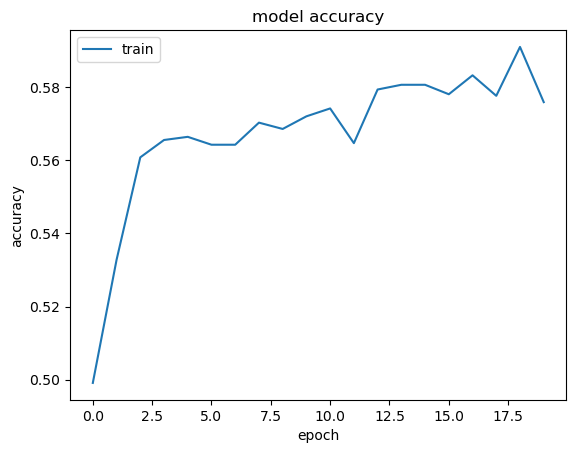

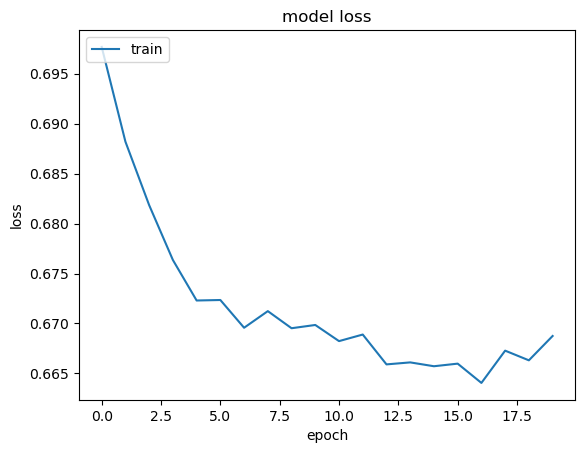

In [269]:
# Plot Accuracy over the epochs
plt.plot(classifier.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('model accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

# Plot Loss over the epochs
plt.plot(classifier.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [270]:
# evaluate the keras model
loss, accuracy = model.evaluate(X_train[:1000], y_train[:1000])
print('Accuracy: %.2f' % (accuracy*100))
print(round(loss,3),round(accuracy,3))


32/32 [==============================] - 11s 293ms/step - loss: 0.6620 - accuracy: 0.5730
Accuracy: 57.30
0.662 0.573


In [271]:
print(round(loss,3),round(accuracy,3))

0.662 0.573


# Test accuracy
Run model predictions on the test data set and report metrics scores, including MCC and F1 

In [272]:
from sklearn import metrics

# #Predict the testing set
predictions = (model.predict(X_test) > 0.5).astype(int)

#Accuracy classification score
acc = float(round(metrics.accuracy_score(y_test, predictions),3))

#Compute the balanced accuracy.
bacc = float(round(metrics.balanced_accuracy_score(y_test, predictions),3))

#Compute the Matthews correlation coefficient (MCC)
mcc = float(round(metrics.matthews_corrcoef(y_test, predictions),3))

#Compute the F1 score, also known as balanced F-score or F-measure.
f1 = float(round(metrics.f1_score(y_test, predictions),3))

#Show results as a DataFrame:
results = {'Accuracy' : [acc], 'Balanced Accuracy' : [bacc], 'MCC' : [mcc], 'F1-Score' : [f1]}
df_results = pd.DataFrame.from_dict(data = results, orient='columns')
print(df_results)

9/9 [==============================] - 4s 275ms/step
   Accuracy  Balanced Accuracy  MCC  F1-Score
0      0.55              0.549  0.1     0.594
